In [1]:
%pip install torch
%pip install torchvision


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import sklearn as sk
from sklearn import decomposition as dec
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.utils.prune as prune
import sklearn.manifold as nonlin
from sklearn.metrics import confusion_matrix as cm
import copy
import pickle as pk
import pandas as pn


In [2]:
torch.cuda.is_available()


True

In [4]:
vggmodel = torchvision.models.vgg11(torchvision.models.VGG11_Weights.DEFAULT)

c:\Users\sulta\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [5]:
vggmodel.eval

<bound method Module.eval of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [3]:
path_train = './images/train'
path_train_2 = './datasets/ck+48'
batch_size = 8
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(degrees=(0,90)), 

    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
    ])
f_train = datasets.ImageFolder(path_train, transform)
f_train_dataloader = DataLoader(f_train, shuffle=True,
                                batch_size=batch_size, num_workers=2)
face_classes = f_train.classes

ck_train = datasets.ImageFolder(path_train_2, transform)
ck_train_loader = DataLoader(ck_train, shuffle=True, batch_size=batch_size, num_workers=2)



mnist_dataset = datasets.MNIST('./datasets/mnist', train=True, 
                               transform=transform, download=True)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, shuffle=True, 
                                           batch_size=batch_size, num_workers=2)
cifar_dataset = datasets.CIFAR10('./datasets/cifar10', train=True,
                               transform=transform, download=True)
cifar_loader = torch.utils.data.DataLoader(cifar_dataset, shuffle=True,
                                           batch_size=batch_size, num_workers=2)





device = torch.device('cuda:0')


Files already downloaded and verified


In [4]:
print(face_classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
data_sample = iter(f_train_dataloader)
sample_im, sample_lbl = next(data_sample)

mnist_data_sample = iter(mnist_loader)
mnist_img_sample, mnist_lbl_sample = next(mnist_data_sample)

cifar_data_sample = iter(cifar_loader)
cifar_img_sample, cifar_lbl_sample = next(cifar_data_sample)


ck_train_sample = iter(ck_train_loader)
cf_image_sample, ck_lbl_sample = next(ck_train_sample)


In [6]:
def show_imgs(sample_im):
    size = len(sample_im)
    fig,ax = plt.subplots(2,4, figsize=(10,10))
    fig.suptitle('smaple images of face expressions')
    row = 0
    column = 0
  
    for a in range(size):
        if (size/2) == a:
           row = +1
           column = 0
        ax[row, column].imshow(sample_im[a][0], cmap='gray') 
        column+=1
        


   
    

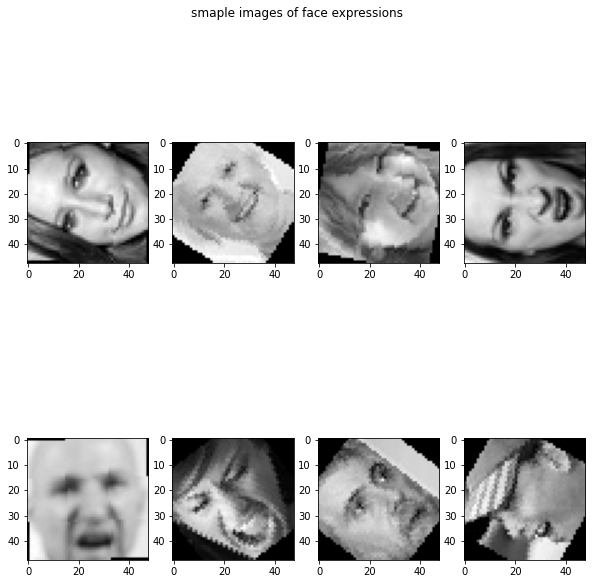

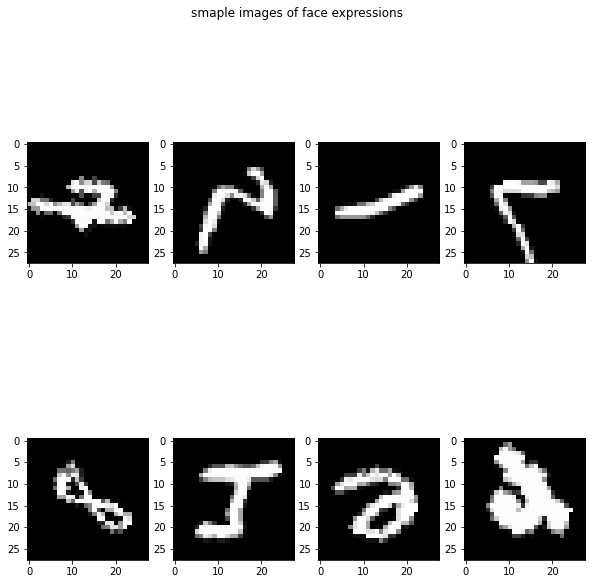

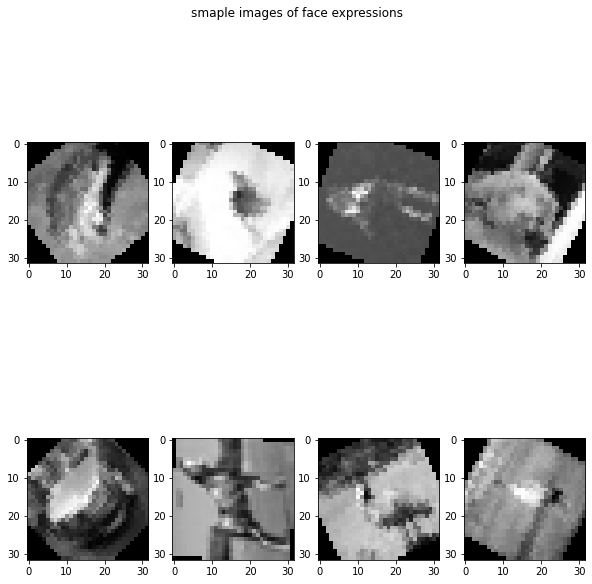

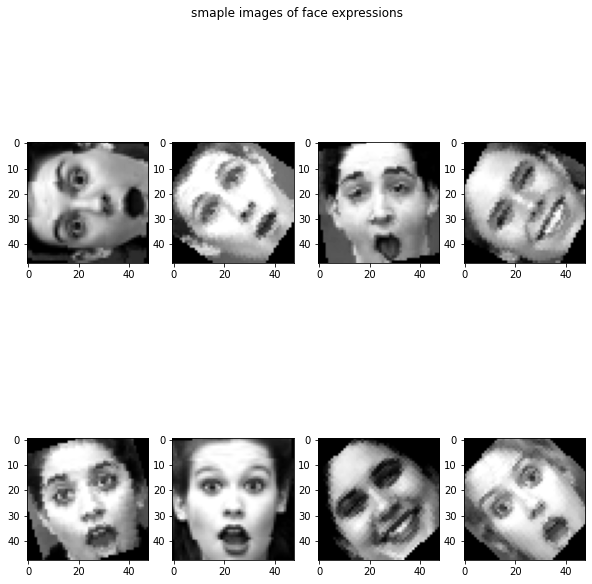

In [7]:
show_imgs(sample_im=sample_im)
show_imgs(sample_im=mnist_img_sample)
show_imgs(sample_im=cifar_img_sample)
show_imgs(cf_image_sample)


In [8]:
for i in sample_lbl:
    print(face_classes[i])

neutral
happy
happy
surprise
fear
angry
angry
happy


 the order of the nn layers:
* Input Image
* Convolutional Layer
* Nonlinearity
* Pooling Layer

In [9]:
class face_nn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=7, stride=1, padding=3)
        self.conv3 = nn.Conv2d(
            in_channels=128, out_channels=512, kernel_size=7, stride=1, padding=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)   
        self.relu = nn.ReLU()
        self.conv4 = nn.Conv2d(
            in_channels=512, out_channels=1024, kernel_size=7, stride=2, padding=3)

        self.lin = nn.Linear(1024, 1024, bias=True)
        self.lin2 = nn.Linear(1024, 1024, bias=True)
        self.lin3 = nn.Linear(1024, 7, bias=True)



    def forward(self, input):
        input = self.conv1(input)
        input = self.relu(input)
        input = self.pool(input)

        input = self.conv2(input)
        input = self.relu(input)
        input = self.pool(input)
        input = self.conv3(input)
        input = self.relu(input)
        input = self.pool(input)
        input = self.conv4(input)
        input = self.relu(input)
        input = self.pool(input)
     
        input = torch.flatten(input,1)
 
        input = self.relu(self.lin(input))
        input = self.relu(self.lin2(input))
        input = self.lin3(input)
        return input

        

        
         



In [10]:
model = face_nn()
test_tensor = torch.rand(4,3,48,48)
ans = model(test_tensor)
print(ans.shape)



torch.Size([4, 7])


In [11]:
def training(model, dataloader, epochs, data_paths):
    model = model.to(device)
    entropy_loss = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    loss_arr = []
    acc_arr = []
    for n in range(epochs):
        total_loss = 0.0
        correct_acc = 0.0
        for data in dataloader:
            temp_acc = 0.0
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            optim.zero_grad()
            with torch.enable_grad():
                output = model(images).to(device)
                loss = entropy_loss(output, labels)
                _,pred= torch.max(output.data, 1)
                loss.backward()
                optim.step()   
            for l,p in zip(labels,pred):
                if l.data == p.data:
                    correct_acc += 1
                    temp_acc +=1
                    


            total_loss +=loss.item()
            loss_arr.append(loss.item())
            acc_arr.append(temp_acc/labels.size(0))
            
            
                
        cal_loss = total_loss / len(dataloader)
        cal_acc = correct_acc / (batch_size * len(dataloader))
        print('the epoch: {}, the loss: {:.3f}, the accuracy: {:.3f}'.format(
            n, cal_loss, cal_acc * 100))
    
    model_data = (loss_arr, acc_arr, model)
    model_save(model_data, data_paths)

def model_save(data, paths):
    loss,acc, model = data
    model_path, data_path = paths
    loss_and_acc = {'accuracy' : acc, 'loss' : loss}
    torch.save(model, model_path)
    with open(data_path, 'wb') as file:
        pk.dump(loss_and_acc, file)
    


it can be observed that increasing the kernel size from 3 to 7 can greatly improve the model prediction

In [12]:
paths = ('./facex_net_v2.pt', 'facex_data_v2.pickle')
model = face_nn()
training(model, ck_train_loader, 25,paths)  


the epoch: 0, the loss: 1.911, the accuracy: 25.305
the epoch: 1, the loss: 1.829, the accuracy: 25.305
the epoch: 2, the loss: 1.813, the accuracy: 25.000
the epoch: 3, the loss: 1.809, the accuracy: 24.695
the epoch: 4, the loss: 1.803, the accuracy: 25.000
the epoch: 5, the loss: 1.808, the accuracy: 26.118
the epoch: 6, the loss: 1.802, the accuracy: 26.016
the epoch: 7, the loss: 1.794, the accuracy: 25.915
the epoch: 8, the loss: 1.778, the accuracy: 25.915
the epoch: 9, the loss: 1.737, the accuracy: 30.386
the epoch: 10, the loss: 1.623, the accuracy: 38.008
the epoch: 11, the loss: 1.481, the accuracy: 42.378
the epoch: 12, the loss: 1.333, the accuracy: 47.154
the epoch: 13, the loss: 1.194, the accuracy: 52.744
the epoch: 14, the loss: 1.094, the accuracy: 56.809
the epoch: 15, the loss: 0.966, the accuracy: 62.805
the epoch: 16, the loss: 0.876, the accuracy: 66.159
the epoch: 17, the loss: 0.816, the accuracy: 68.902
the epoch: 18, the loss: 0.761, the accuracy: 69.207
the

We can observe that tuning the kernel size(kernel_size=7) in the convolutional layers improve the results by a little, by increasing prediction accuracy by riughly 10%, where previous model achieved the accuracy of 50 and new model the accuracy of 60

In [16]:
training(model, f_train_dataloader, 25) # small face expression datasets


TypeError: training() missing 1 required positional argument: 'data_paths'

- confusion matrix vis
- sensitivity and specificity

In [104]:
# d = sk.metrics.classification_report()
def tp(model, dataloder) -> tuple:
    model = model.to(device)
    classes_cm = {}
    pred_seq = []
    actual_seq = []
    for x in face_classes:
        classes_cm[x] = [0, 0, 0, 0]
   
    for data in dataloder:
        images,labels = data
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _,pred = torch.max(output, 1)
        for p, lbl in zip(pred, labels):
            predic = p.data.cpu().detach().numpy()
            target = lbl.data.cpu().detach().numpy()
            pred_seq.append(face_classes[predic])
            actual_seq.append(face_classes[target])
            if p.data == lbl.data:
                classes_cm[face_classes[p.data]][0]+=1 #true positives
            else:
                classes_cm[face_classes[p.data]][1] +=1 #true negatives
            if lbl.data != p.data:
                classes_cm[face_classes[lbl.data]][2] +=1 #false negatives
    for key in classes_cm.keys():
          for key2 in classes_cm.keys():
               if key == key2: continue
               classes_cm[key][3] += classes_cm[key2][0] + classes_cm[key2][1] + classes_cm[key2][2]
                   
    confusion_matrix = cm(y_true=actual_seq, y_pred=pred_seq, labels=face_classes)

    return (confusion_matrix, classes_cm)
def classifier_metrics(classes_cm):
    # first is precision, second is recall/sensitivity, third specificity, fourth f1-score
    metrics = {classes: [0,0,0,0] for classes in face_classes}
    for key in classes_cm.keys():
        [tp,fp,fn,tn] = classes_cm[key]
        metrics[key][0] = tp/(tp + fp) 
        metrics[key][1] = tp/(tp + fn)
        metrics[key][2] = tn/(tn + fp)
    for key in metrics:
        [prec, recall, spec, f1] = metrics[key]
        f1 = 2 * ((prec * recall)/(prec + recall))
        metrics[key][3] = f1
    return metrics
    # f1
    # sensitivity
    # specificity 
    # precision


In [105]:
%pip install Jinja2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [106]:
def dataframe(data,labels):
    df = pn.DataFrame(data)
    df.index = labels
    return df

In [110]:
con_mat, tp_classes = tp(model, ck_train_loader)
class_metrics = classifier_metrics(tp_classes)
# rows actual
# columns prediction

print(con_mat)
ass = dataframe(tp_classes, ['TP', 'FP', 'FP', 'FN'])
print(ass)

pn.set_option('display.float_format', '{:.3}'.format)
ass2 = dataframe(class_metrics, ['precision', 'sensitivity', 'specificity', 'f1-score'])

print(ass2)


[[129   0   6   0   0   0   0]
 [ 13  16   3  11   1   7   3]
 [  8   0 167   1   1   0   0]
 [  4   3   7  53   5   0   3]
 [  0   0   8   3 196   0   0]
 [ 57   0   1   1   0  23   2]
 [  1   0   4   1   0   0 243]]
    angry  disgust  fear  happy  neutral   sad  surprise
TP    129       16   167     53      196    23       243
FP     83        3    29     17        7     7         8
FP      6       38    10     22       11    61         6
FN    917     1078   929   1043      921  1044       878
             angry  disgust  fear  happy  neutral   sad  surprise
precision    0.608    0.842 0.852  0.757    0.966 0.767     0.968
sensitivity  0.956    0.296 0.944  0.707    0.947 0.274     0.976
specificity  0.917    0.997  0.97  0.984    0.992 0.993     0.991
f1           0.744    0.438 0.895  0.731    0.956 0.404     0.972


the way max pooling behaves together with nonlinearity relu, such concept can be utilized together with dimensional reduction and pruning of the network

In [111]:
ass.style

,angry,disgust,fear,happy,neutral,sad,surprise
TP,129,16,167,53,196,23,243
FP,83,3,29,17,7,7,8
FP,6,38,10,22,11,61,6
FN,917,1078,929,1043,921,1044,878


In [116]:
ass2.style.format(precision=3)

,angry,disgust,fear,happy,neutral,sad,surprise
precision,0.608,0.842,0.852,0.757,0.966,0.767,0.968
sensitivity,0.956,0.296,0.944,0.707,0.947,0.274,0.976
specificity,0.917,0.997,0.970,0.984,0.992,0.993,0.991
f1,0.744,0.438,0.895,0.731,0.956,0.404,0.972


In [ ]:
# fig,ax = plt.subplots()
# x = []
# a = [i for i in range(len(face_classes))]
# print(a)
# im = ax.imshow(confusion_matrix)


In [ ]:
def maxrelu(model,output):
    res = model.pool(output)
    res = nn.functional.relu(res)
    return res


def relumax(model, output):
    res = nn.functional.relu(output)
    res = model.pool(res)
    return res


In [ ]:
#random testing
output = model(random_tensor)
result1 = maxrelu(model,output)
result2 = relumax(model, output)


In [ ]:
print(output)

tensor([[[-0.5854, -0.4334, -0.4620,  ..., -0.3623, -0.4927, -0.4911],
         [-0.4282, -0.3735, -0.4298,  ..., -0.5430, -0.5210, -0.5024],
         [-0.3902, -0.5418, -0.5382,  ..., -0.4798, -0.5627, -0.5676],
         ...,
         [-0.4154, -0.5787, -0.6319,  ..., -0.4587, -0.5055, -0.4262],
         [-0.4933, -0.4061, -0.5930,  ..., -0.5507, -0.5121, -0.5118],
         [-0.5668, -0.4956, -0.4988,  ..., -0.4812, -0.5677, -0.6205]],

        [[-0.0437, -0.1409, -0.1206,  ...,  0.0071,  0.1222,  0.0787],
         [-0.0967,  0.0355, -0.1167,  ..., -0.0636, -0.0451,  0.1072],
         [ 0.0372, -0.0315,  0.0454,  ...,  0.0620,  0.0433, -0.0120],
         ...,
         [-0.0088,  0.1452,  0.1720,  ..., -0.0058, -0.0948,  0.0625],
         [-0.0009,  0.0371,  0.0851,  ...,  0.2091,  0.0803, -0.0294],
         [ 0.0715,  0.0370,  0.1640,  ...,  0.0084,  0.0630,  0.0808]],

        [[-0.2271, -0.2085, -0.2280,  ..., -0.1504, -0.3306, -0.3041],
         [-0.1465, -0.0239, -0.2955,  ..., -0